## setup

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import os
import glob
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, log_loss, accuracy_score

/opt/conda/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
import warnings
warnings.filterwarnings('ignore')

### functions

In [20]:
def determine_alpha(y, X, alphas, splits):
    results = pd.DataFrame()
    for a in alphas:
        _, _, accuracy = cv_regression(y, X, a, splits)
        accuracy['alpha'] = a
        results = results.append(accuracy)
    
    mean = results.groupby('alpha').mean()
    stdev = results.groupby('alpha').std()
    summary = mean.join(stdev,lsuffix='_mean', rsuffix='_std').reset_index()

    return summary


def cv_regression(y, X, alpha, splits, get_prediction=False):
    pvalue = pd.DataFrame()
    coeff = pd.DataFrame()
    accuracy = pd.DataFrame()
    prediction = y.copy()
    prediction['pred'] = -1
    prediction['pred_bin'] = -1
    
    if splits ==  1:
        model = sm.Logit(y, X)
        fit = model.fit_regularized(method='l1', alpha=alpha, maxiter=10000, disp=False)

        y_predict = model.predict(fit.params, X)
        y_binary = y_predict.round()
        prediction.iloc[:,1] = y_predict
        prediction.iloc[:,2] = y_binary
        
        fpr, tpr, thresholds = roc_curve(y, y_predict)
        aucVal = auc(fpr, tpr)
        accVal = accuracy_score(y, y_binary)
        accuracy = accuracy.append(pd.Series(data=[accVal, aucVal], index=['accuracy', 'auc']), ignore_index=True)
        coeff = coeff.append(fit.params, ignore_index=True)
        pvalue = pvalue.append(fit.pvalues, ignore_index=True)
        
    
    else:
        kf = KFold(n_splits=splits, shuffle=True)
        for i, [train_index, test_index] in enumerate(kf.split(X)):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            model = sm.Logit(y_train, X_train)
            fit = model.fit_regularized(method='l1', alpha=alpha, maxiter=10000, disp=False)
            y_predict = model.predict(fit.params, X_test)
            y_binary = y_predict.round()
            prediction.iloc[test_index,1] = y_predict
            prediction.iloc[test_index,2] = y_binary

            fpr, tpr, thresholds = roc_curve(y_test, y_predict)
            aucVal = auc(fpr, tpr)
            accVal = accuracy_score(y_test, y_binary)

            accuracy = accuracy.append(pd.Series(data=[accVal, aucVal], index=['accuracy', 'auc']), ignore_index=True)
            coeff = coeff.append(fit.params, ignore_index=True)
            pvalue = pvalue.append(fit.pvalues, ignore_index=True)

    if get_prediction:
        return(coeff,pvalue,accuracy,prediction)
    else:
        return(coeff,pvalue,accuracy)

def jacknife(yFull, XFull, alpha, splits, all_but=False):
    factors = list(XFull.columns)
    factors.remove('Intercept')

    columns = [f'run{x+1}' for x in range(0,splits)]
    df = pd.DataFrame(index=factors, columns=columns)
 
    for factor in factors:
        if all_but:
            X = XFull.drop(factor,axis=1)
        else:
            X = XFull.loc[:,['Intercept', factor]]

        coeff, pvalue, accuracy = cv_regression(yFull, X, alpha, splits)
        auc = list(accuracy['auc'])
        df.loc[factor] = auc
    
    return(df)


def run_regression(dataset,output,drops,alpha,splits):
    y, X, df = create_data(dataset,'datasets.xlsx', drop=drops, return_df=True)
    coeff, pvalue, accuracy, prediction = cv_regression(y, X, alpha, splits, get_prediction=True)

    prediction = prediction.drop('presence',axis=1)
    prediction_df = pd.merge(df,prediction,left_index=True,right_index=True)
    prediction_df['correct'] = (prediction_df['presence']==prediction_df['pred_bin']).astype('int')

    jth_df = jacknife(y, X, 5, 10, all_but=False)
    allbut_df = jacknife(y, X, 5, 10, all_but=True)

    coeff_summary = pd.DataFrame({'coefficient':coeff.mean(axis=0, skipna = True),
                                  'p_value':pvalue.mean(axis=0, skipna = True)})
    coeff_summary['|coefficient|'] = coeff_summary['coefficient'].abs()
    coeff_summary = coeff_summary.sort_values(by='p_value')
    acc_summary = pd.DataFrame({'results':accuracy.mean(axis=0, skipna = True)})

    with pd.ExcelWriter(output) as writer:
        acc_summary.to_excel(writer, sheet_name='acc_summary')
        coeff_summary.to_excel(writer, sheet_name='coeff_summary')
        accuracy.to_excel(writer, sheet_name='accuracy', index=False)
        coeff.to_excel(writer, sheet_name='coefficients', index=False)
        pvalue.to_excel(writer, sheet_name='p_values', index=False)
        jth_df.to_excel(writer, sheet_name='jth', index=False)
        allbut_df.to_excel(writer, sheet_name='allbut', index=False)
        prediction_df.to_excel(writer, sheet_name='prediction', index=False)

    print(acc_summary)
    print(confusion_matrix(prediction_df['presence'], prediction_df['pred_bin']))
    return

In [4]:
cd /home/micromamba/data

/home/micromamba/data


In [5]:
# geology groups
# bulk_groups = ['sandstone', 'mudstone']
# units = ['mangarere', 'vinhill', 'tangahoe', 'tikapu', 'kaiiwi', 'lateplio',
#        'okiwalow', 'maxwell', 'okehu', 'paparangi', 'shakes', 'okiwaup',
#        'utiku', 'whenuakura']

# columns to keep
# keeps = ['Name', 'class', 'activity', 'incision', 'slope', 'forest', 'tobia', 'rainfall', 'pga',
#         'spi', 'max_elev', 'age_qt', 'cos_aspect', 'uplift', 'sin_aspect', 'dip',
#         'dTOAfault', 'soil_moist',  'dTOfault', 'age_epl']

In [6]:
y_name = 'activity'
x_names = ['incision', 'slope', 'forest', 'tobia', 'rainfall', 'pga',
        'spi', 'max_elev', 'age_qt', 'cos_aspect', 'uplift', 'sin_aspect', 'dip',
        'dTOAfault', 'soil_moist',  'dTOfault', 'age_epl', 'profc', 'planc','std_elev','river_dist',]

# x_names = ['incision', 'slope', 'forest', 'tobia', 'rainfall', 'pga',
#         'spi', 'max_elev', 'age_qt', 'cos_aspect', 'uplift', 'sin_aspect', 'dip',
#         'dTOAfault', 'soil_moist',  'dTOfault', 'age_epl']

In [7]:
planar = pd.read_csv('log_reg/zonal_stats_planar.csv')
rotational = pd.read_csv('log_reg/zonal_stats_rotational.csv')

zstats = planar.append(rotational).reset_index(drop=True)
zstats = zstats.loc[zstats['presence'] == 1]
zstats['Name'] = zstats['Name'].astype(int)

activity = pd.read_csv('landslides/large_landslides_activeV2.csv').loc[:,['Name','evidence']]
activity['Name'] = activity['Name'].astype(int)
zstats = zstats.set_index('Name').join(activity.set_index('Name')).reset_index()
zstats = zstats.rename(columns={'evidence':'activity'})
zstats.loc[zstats['activity'] == -1,'activity'] = 0

zstats = zstats[[y_name]+x_names].dropna()

In [8]:
zstats.shape

(870, 22)

## regression

#### scale data

In [9]:
# Create the Scaler object
scaler = preprocessing.StandardScaler()

# Fit data to the scaler object
scaled_data = scaler.fit_transform(zstats[x_names])
input_data = pd.DataFrame(scaled_data, columns=x_names).join(zstats[y_name])
equation = f'activity ~ {" + ".join(x_names)}'
y, X = dmatrices(equation, data=input_data, return_type='dataframe')

#### inspect variable inflation factor and correlation

In [10]:
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(1).sort_values('VIF',ascending=False).reset_index(drop=True)

,VIF,features
0,7.5,uplift
1,7.3,soil_moist
2,6.2,max_elev
3,6.1,rainfall
4,5.2,age_qt
5,4.9,tobia
6,4.2,slope
7,3.9,pga
8,2.6,dip
9,2.4,age_epl


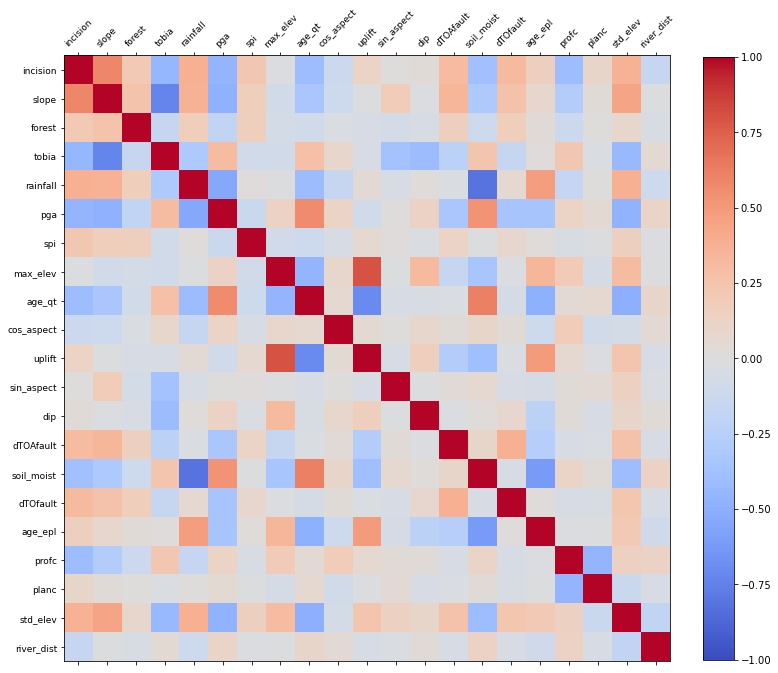

In [11]:
corr = X.iloc[:,1:].corr().round(2)
names = list(corr.columns)
pos = np.arange(len(names))

f, ax = plt.subplots(1,1,figsize=(12,12))

cax = ax.matshow(corr,cmap='coolwarm',vmin=-1,vmax=1)
xtick = plt.xticks(pos,names,rotation=45,fontsize=9)
ytick = plt.yticks(pos,names,fontsize=9)

f.colorbar(cax,fraction=0.045)

In [12]:
drop_cols = list(vif.loc[vif['VIF'] > 7,'features'])

In [13]:
X = X.drop(columns=drop_cols)
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(1).sort_values('VIF',ascending=False).reset_index(drop=True)

,VIF,features
0,4.8,tobia
1,4.2,slope
2,3.6,pga
3,3.3,age_qt
4,2.9,max_elev
5,2.4,dip
6,2.3,age_epl
7,2.2,std_elev
8,2.2,incision
9,2.1,rainfall


#### select alpha

In [30]:
alpha_trials = determine_alpha(y, X, np.logspace(0,3,30), 10)

[Text(0.5, 0, 'log10 alpha'), Text(0, 0.5, 'accuracy')]

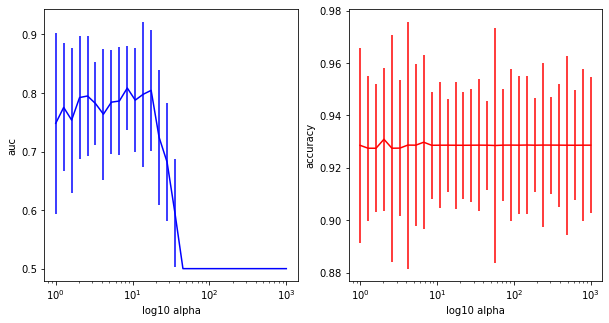

In [31]:
f, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

ax1.errorbar(alpha_trials['alpha'],alpha_trials['auc_mean'],yerr=alpha_trials['auc_std'],color='blue')
ax1.semilogx()
ax1.set(xlabel='log10 alpha',ylabel='auc')
# ax1.set_xlim(0,10)

ax2.errorbar(alpha_trials['alpha'],alpha_trials['accuracy_mean'],yerr=alpha_trials['accuracy_std'],color='red')
ax2.semilogx()
ax2.set(xlabel='log10 alpha',ylabel='accuracy')

In [32]:
alpha = 5
alpha_trials.loc[(alpha_trials['alpha']>=alpha-0.5) & (alpha_trials['alpha']<=alpha+0.5)]

,alpha,accuracy_mean,auc_mean,accuracy_std,auc_std
7,5.298317,0.928655,0.784259,0.031027,0.08903


#### run regression

In [33]:
alpha = 5
splits = 10

In [34]:
coeff, pvalue, accuracy = cv_regression(y, X, alpha, splits)
jth_df = jacknife(y, X, alpha, splits, all_but=False)
allbut_df = jacknife(y, X, alpha, splits, all_but=True)

In [35]:
coeff_summary = pd.DataFrame({'coefficient':coeff.mean(axis=0, skipna = True),
                              'p_value':pvalue.mean(axis=0, skipna = True)})
coeff_summary['|coefficient|'] = coeff_summary['coefficient'].abs()
coeff_summary = coeff_summary.sort_values(by='|coefficient|',ascending=False)
acc_summary = pd.DataFrame({'results':accuracy.mean(axis=0, skipna = True)})

In [36]:
acc_summary

,results
accuracy,0.929818
auc,0.782827


In [37]:
coeff_summary

,coefficient,p_value,|coefficient|
Intercept,-2.830662,9.284942e-59,2.830662
slope,-0.882267,6.436829e-05,0.882267
std_elev,0.503687,1.260353e-03,0.503687
rainfall,0.341493,6.154141e-02,0.341493
age_epl,0.249815,1.871871e-01,0.249815
dip,-0.139568,4.082297e-01,0.139568
age_qt,-0.047513,8.023445e-01,0.047513
spi,0.044903,7.117210e-01,0.044903
incision,0.041119,8.018958e-01,0.041119
dTOfault,-0.038255,7.657320e-01,0.038255


## plots

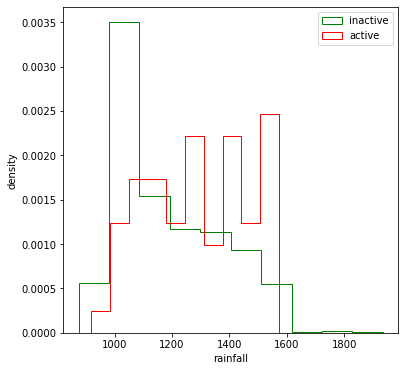

In [38]:
metric = 'rainfall'

state = {0:{'label':'inactive','color':'green'},
         1:{'label':'active','color':'red'}}

f, ax = plt.subplots(1,1,figsize=(6,6))
for s in state:
    x_plot = zstats.loc[zstats['activity'] == s, metric]
    ax.hist(x_plot, bins=10, density=True, histtype='step', color=state[s]['color'],label=state[s]['label'])

ax.set(xlabel=metric,ylabel='density')
plt.legend()

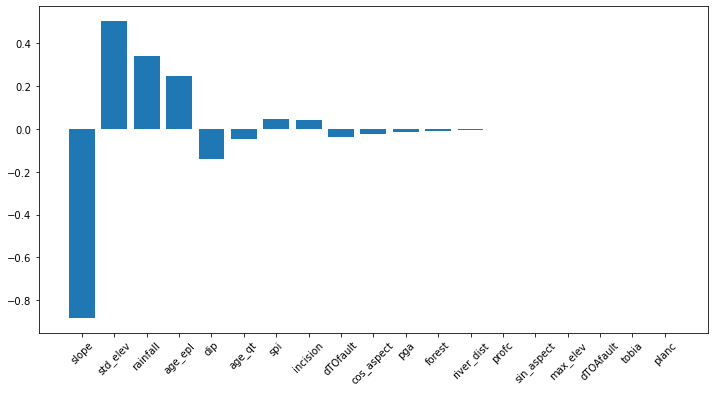

In [39]:
df_plot = coeff_summary.drop(index='Intercept')

f, ax = plt.subplots(1,1,figsize=(12,6))
ax.bar(df_plot.index,df_plot['coefficient'])
xtick = plt.xticks(rotation=45,fontsize=10)

In [40]:
jth_means = jth_df.mean(axis=1)[coeff_summary.drop(index='Intercept').index]
allbut_means = allbut_df.mean(axis=1)[coeff_summary.drop(index='Intercept').index]

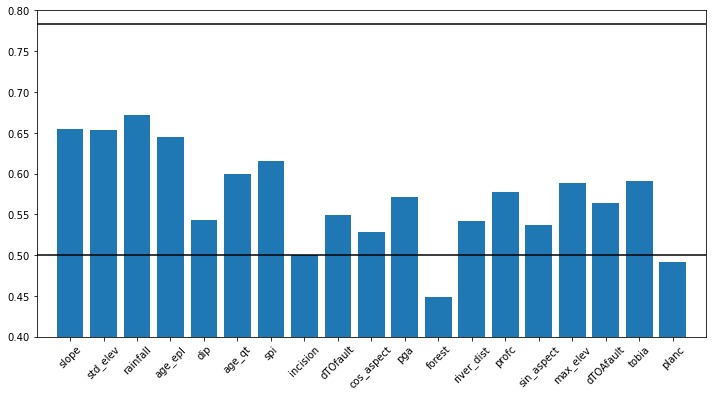

In [41]:
f, ax = plt.subplots(1,1,figsize=(12,6))
ax.bar(jth_means.index,jth_means)
ax.hlines((0.5,acc_summary.loc['auc','results']),xmin=-1,xmax=X.shape[1]-1,color='black')
plt.ylim(0.4,0.8)
plt.xlim(-1,X.shape[1]-1)
xtick = plt.xticks(rotation=45,fontsize=10)

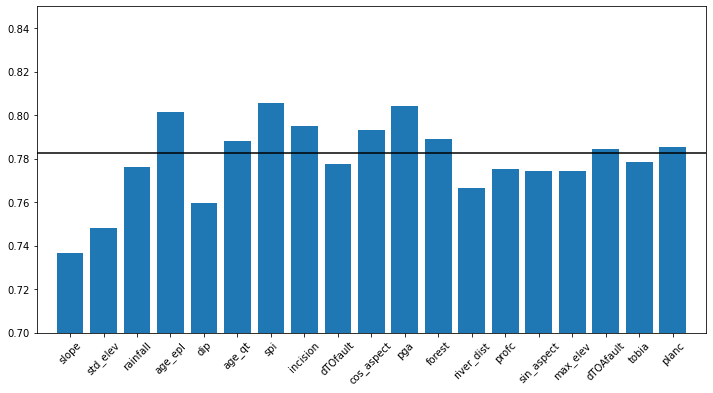

In [42]:
f, ax = plt.subplots(1,1,figsize=(12,6))
ax.bar(allbut_means.index,allbut_means)
ax.hlines(acc_summary.loc['auc','results'],xmin=-1,xmax=X.shape[1]-1,color='black')
plt.ylim(0.7,0.85)
plt.xlim(-1,X.shape[1]-1)
xtick = plt.xticks(rotation=45,fontsize=10)

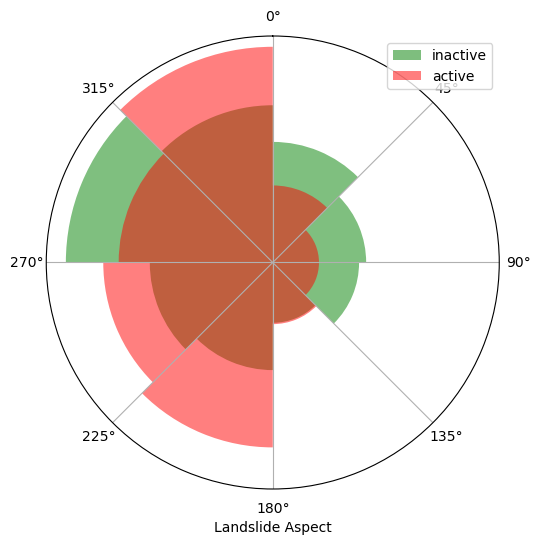

In [103]:
aspect = pd.DataFrame()
aspect['activity'] = zstats['activity']
aspect['aspect'] = np.rad2deg(np.arctan2(zstats['sin_aspect'],zstats['cos_aspect']))

state = {0:{'label':'inactive','color':'green'},
         1:{'label':'active','color':'red'}}
bins = 8

fig = plt.figure(figsize=(6,6),dpi=100)
ax = fig.add_subplot(projection='polar')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_xlabel('Landslide Aspect')
ax.set_rticks(ticks=[])

for s in state:
    df = aspect.loc[aspect['activity']==s].copy()
    h, b = np.histogram(df.aspect, bins=np.linspace(-180, 180, bins+1), density=True)
    b = np.deg2rad((b[1:] + b[:-1]) / 2)
    width = (2*np.pi) / bins
    ax.bar(b, h, width=width, bottom=0.0, color=state[s]['color'],label=state[s]['label'],alpha=0.5)

plt.legend()